# 3章　分類
## 3.1 MNIST

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [1]:
from sklearn.datasets import fetch_openml
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X,y = mnist['data'], mnist['target']
y = np.array(list(map(lambda x:int(x), y)))
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


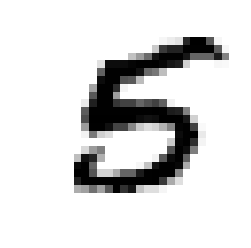

In [4]:
some_digit = X[20000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [5]:
y[20000]

5

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 56000 vs 14000

In [7]:
shuffle_index = np.random.permutation(len(X_train)) #arg(int)までの連番をランダム並べ替えして返す
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 3.2 2項分類器の訓練

In [8]:
from sklearn.linear_model import SGDClassifier

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 性能指標

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [13]:
cross_val_score(sgd_clf,X_train, y_train_5,cv=3, scoring='accuracy')

array([0.96367922, 0.94926876, 0.95548055])

In [14]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91053731, 0.91010875, 0.90935391])

In [16]:
y_train_predict = cross_val_predict(sgd_clf, X_train,y_train_5, cv=3)

In [17]:
confusion_matrix(y_train_5, y_train_predict)

array([[50013,   947],
       [ 1509,  3531]])

**row:実際のクラス、col:予測したクラス  
上がfalse(陰性), 下がtrue(陽性)**
* 実際クラス false -> false と予測: 真陰性(TN)
* 実際クラス false -> true  と予測: 偽陽性(FP) 誤って陽性に分類、と覚える
* 実際クラス true -> true   と予測: 真陽性(TP)
* 実際クラス true -> false  と予測: 偽陰性(FN) 誤って陰性に分類、と覚える

### 注目するべきは、陽性の正解率→適合率(precision)と呼ぶ
* $ precision = \frac{TP+FP}{TP} $

また適合率は再現率(recall)という別の指標とともに用いいられる  
* $ recall = \frac{TP+FN}{TP} $

### 基本的に2項分類器の指標
単純な比較の指標として、適合率と再現率の調和平均をとったF値を用いる
* ### $ F = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

In [18]:
precision_score(y_train_5, y_train_predict)

0.7885216614560071

In [19]:
recall_score(y_train_5, y_train_predict)

0.700595238095238

In [20]:
f1_score(y_train_5, y_train_predict)

0.7419625971842824

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([241071.71633535])

In [22]:
threshold = 0
y_some_digit_predict= (y_scores > threshold)
y_some_digit_predict

array([ True])

In [23]:
threshold = 100000
y_some_digit_predict= (y_scores > threshold)
y_some_digit_predict

array([ True])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
# y_scores: 各インスタンスに対しての全てのスコアを求める

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

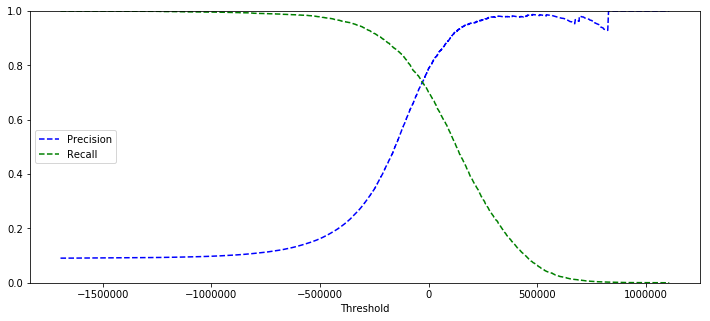

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
plt.figure(figsize=(12,5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
#90%の適合率を目指す→threshold=300000
threshold = 100000
y_train_pred_90 = (y_scores >threshold)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9019863236730706
0.5496031746031746


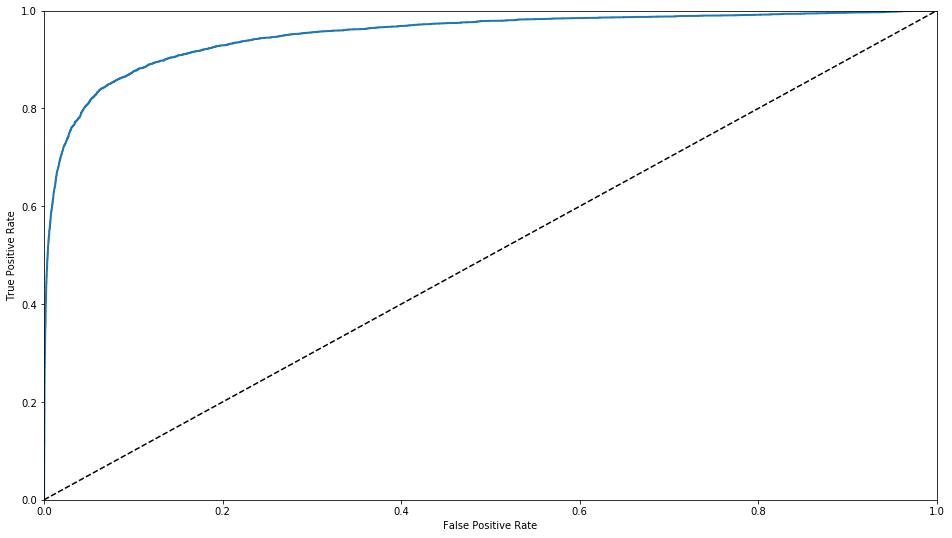

In [28]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

plt.figure(figsize=(16,9))
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores)

0.9506058011574593

In [30]:
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3 ,method='predict_proba')

In [31]:
y_scores_forest = y_proba_forest[:, 1] #スライスを使って、陽性の部分の確率を入手
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

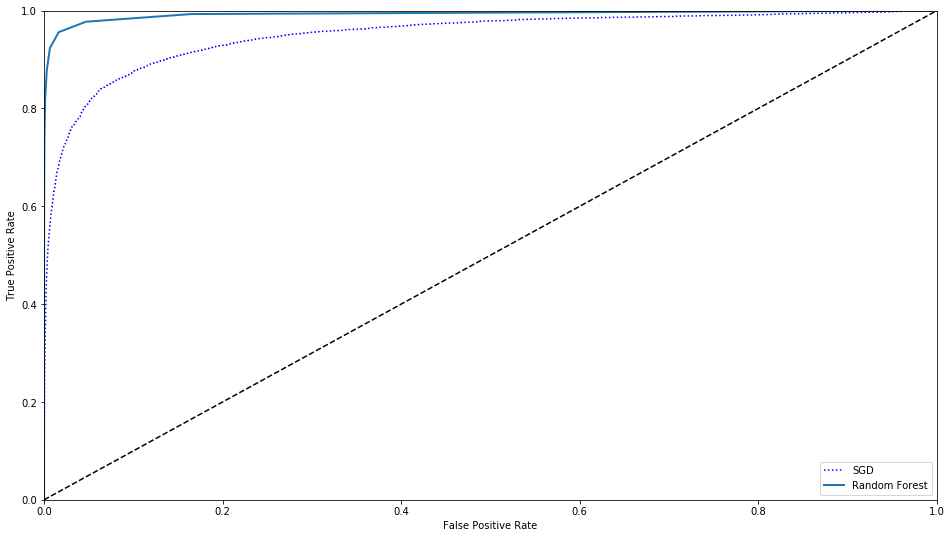

In [32]:
plt.figure(figsize=(16,9))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc= "lower right")
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926882214653261

In [34]:
y_pred_forest = cross_val_predict(forest_clf,X_train, y_train_5, cv=3)

In [35]:
precision_score(y_train_5, y_pred_forest)

0.9854554124940391

In [36]:
recall_score(y_train_5, y_pred_forest)

0.8200396825396825

## 3.4 多クラス分

多クラスの分類をするには、0検出器・・・9検出器のようなものをその分類クラス数分作成し、もっともスコアの良いものを取ればいい。なおsklearnは自動的にやってくれる模様(one_versus_all法:OVA法)

一方一対一での分類器を作成し、それでもっとも勝利したクラスを予測値とする方法(one_versus_one法:OVO法)もある

In [37]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

In [38]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5])

In [39]:
some_digit_score = sgd_clf.decision_function([some_digit])
some_digit_score

array([[ -472637.29973188,  -624589.20069214,  -764924.61575264,
         -507821.93005478,  -309690.62300948,   241071.71633535,
         -364668.85400154, -1240265.55875549,  -560076.09415983,
         -681212.76047854]])

In [40]:
sgd_clf.classes_[np.argmax(some_digit_score)]

5

In [41]:
#強制的にOVO法

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))

len(ovo_clf.estimators_)

[5]


45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0.8, 0. , 0. , 0.1, 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85275055, 0.86178818, 0.86031933])

In [45]:
#85%なのでまだ上昇の余地あり。改善として、Xを標準化する
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90926134, 0.90968018, 0.91084441])

In [46]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mat = confusion_matrix(y_train, y_train_pred)
conf_mat

array([[5398,    3,   16,    9,   10,   45,   40,    5,   31,    3],
       [   1, 6068,   40,   16,    5,   32,    9,    8,   88,   10],
       [  61,   36, 4991,   90,   85,   19,   93,   55,  164,   16],
       [  43,   35,  135, 5004,    4,  202,   31,   43,  127,   84],
       [  16,   29,   32,    4, 5098,    7,   56,   26,   60,  201],
       [  71,   41,   23,  166,   66, 4279,  116,   25,  157,   96],
       [  35,   24,   40,    1,   43,   86, 5198,    7,   46,    0],
       [  29,   26,   70,   29,   52,    7,    6, 5306,   16,  249],
       [  49,  144,   79,  128,   14,  151,   53,   23, 4683,  144],
       [  42,   32,   25,   80,  157,   33,    3,  166,   69, 4931]])

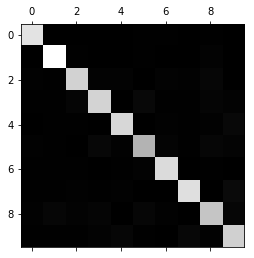

In [47]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

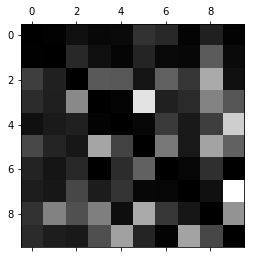

In [48]:
#暗すぎてよくわからないので、絶対数ではなく、絶対率に変換→対角成分を0にする

row_sums = conf_mat.sum(axis=1)# 1で行成分の和
norn_conf_mat = conf_mat / row_sums

np.fill_diagonal(norn_conf_mat, 0)
plt.matshow(norn_conf_mat, cmap=plt.cm.gray)
plt.show()

In [49]:
# 3 vs 5 and 7 vs 9がよくない→改善案として、曲線を取るようにする等

In [50]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances)-1) // images_per_row+1# //は小数点切り捨て
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row :(row+1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")

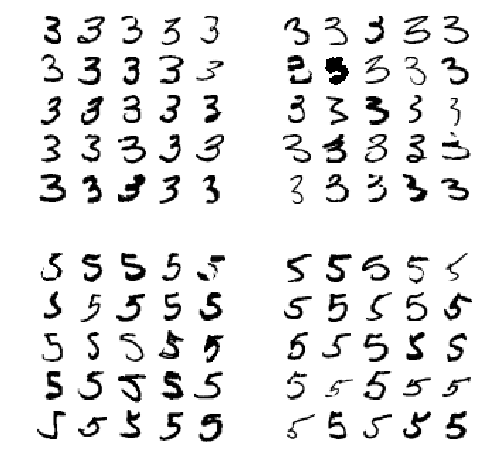

In [51]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(2,2,2)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(2,2,3)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(2,2,4)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 3.6 多ラベル分類

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
y_train_large =(y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
%%time
knn_clf = KNeighborsClassifier()

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1) #何故か実行できない
f1_score(y_multilabel, y_train_knn_pred, average='macro')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


0.9760822332568068

## 3.7 多出力分類

In [56]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

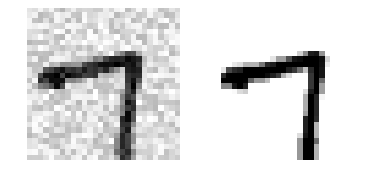

In [57]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [58]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])

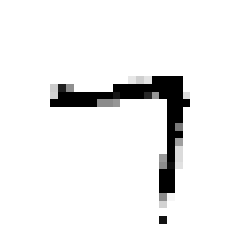

In [60]:
plot_digit(clean_digit)

## 3.8 演習問題
### (1)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [63]:
%%time
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = Gr
idSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 554.0min remaining: 85.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 554.1min finished


CPU times: user 13.1 s, sys: 939 ms, total: 14 s
Wall time: 9h 14min 16s


In [65]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [66]:
grid_search.best_score_

0.9727142857142858

In [68]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test,y_pred)

0.9731428571428572

### (2)

In [8]:
from scipy.ndimage import shift

def image_shift(dx, dy, image):
    image = image.reshape(28,28)
    image = shift(image, shift=[dy,dx],cval=0)
    return image.reshape([-1])
    

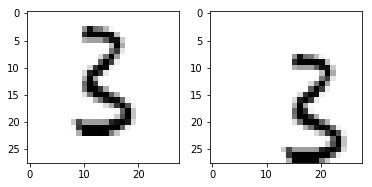

In [9]:
plt.subplot(121)
plt.imshow(X_train[2000].reshape(28,28),cmap=matplotlib.cm.binary)
plt.subplot(122)
plt.imshow(image_shift(5, 5, X_train[2000]).reshape(28,28), cmap=matplotlib.cm.binary)

In [10]:
X_train_argumented = [image for image in X_train]
y_train_argumented = [image for image in y_train]

In [13]:
dxs = [0, 1, 0, -1]
dys = [1, 0, -1, 0]
for dx,dy in zip(dxs, dys):
    for image,label in zip(X_train, y_train):
        X_train_argumented.append(image_shift(dx,dy, image))
        y_train_argumented.append(label)

In [15]:
X_train_argumented = np.array(X_train_argumented)
y_train_argumented = np.array(y_train_argumented)

In [16]:
%%time
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train_argumented, y_train_argumented)

CPU times: user 31.9 s, sys: 226 ms, total: 32.1 s
Wall time: 32.1 s


In [18]:
%% time
y_pred_argumented = knn_clf.predict(X_test)#時間かかる
precision_score(y_test, y_pred_argumented)

ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [22]:
accuracy_score(y_test, y_pred_argumented)

0.9797142857142858